In [30]:
import sys
sys.path.insert(0, './../hyperAFM')
import matplotlib.pyplot as plt
import numpy as np
import util
import jeff_hypir
%matplotlib inline

from matplotlib.mlab import PCA
from sklearn.decomposition import PCA as sklearnPCA

In [21]:
#load hyperspectral image
hyperspectral = util.HyperImage('./../../../../../Desktop/Set2/Film12topo_0058.txt')
hypertopo = hyperspectral.channel_data[:,:,0]
hyperimage = hyperspectral.hyper_image
#take average of all spectra in hyperspectral image. 
#use it to find peaks and display the average spectrum. 
peaklocs, spectrum = jeff_hypir.get_hyper_peaks(hyperimage, threshold=0.01)
#load cAFM image
cAFM4 = util.load_ibw('./../Data/SKPMcAFM_set2/MAPIFilm12cAFM_0004.ibw')
topo4 = cAFM4[:,:,0]

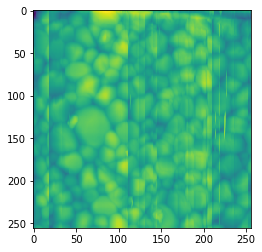

In [22]:
#cAFM topo
plt.imshow(topo4)

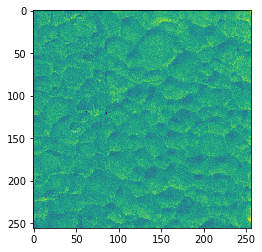

In [23]:
#hyper topo
plt.imshow(hypertopo)

In [27]:
aligned = util.align_images(hyperspectral.channel_data, cAFM4)
alignedtopo = aligned[:,:,0]

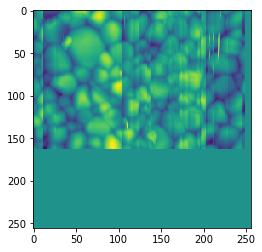

In [28]:
plt.imshow(alignedtopo)

In [31]:
alignedmystery=aligned[:,:,7]

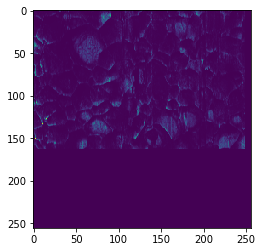

In [32]:
plt.imshow(alignedmystery)

In [33]:
alignedmystery[1][1]

1.0446053e-11